In [4]:
import os
from chusai import FindFiles, CfgFormat, SampleSet, CsiFormatConvrt
from itertools import accumulate
import numpy as np

## 不同轮次的输入数据可放在不同文件夹中便于管理，这里用户可以自定义
PathSet = {0:"./TestData", 1:"./CompetitionData1", 2:"./CompetitionData2", 3:"./CompetitionData3", 4:"./CompetitionData4"}
PrefixSet = {0:"Test" , 1:"Round1", 2:"Round2", 3:"Round3", 4:"Round4"}

Ridx = 0 # 设置比赛轮次索引，指明数据存放目录。0:Test; 1: 1st round; 2: 2nd round ...
PathRaw = "./chusai_data/" + PathSet[Ridx]
PathOut = "./outputs/" + PathSet[Ridx]
Prefix = PrefixSet[Ridx]

# names= FindFiles(PathRaw) # 查找文件夹中包含的所有比赛/测试数据文件，非本轮次数据请不要放在目标文件夹中

# dirs = os.listdir(PathRaw)
na = '003'
dirs = os.listdir(PathRaw)
names = []  # 文件编号
files = []
for f in sorted(dirs):
    if f.endswith('.txt'):
        files.append(f)
for f in sorted(files):
    if f.find('CfgData') != -1 and f.endswith('.txt'):
        names.append(f.split('CfgData')[-1].split('.txt')[0])
        
# Np_total = 0
# for na in names[1:]:
#     Cfg = CfgFormat(PathRaw + '/' + Prefix + 'CfgData' + na + '.txt')
#     Np_total += Cfg['Np'].sum()
# print(Np_total) #520
Cfg = CfgFormat(PathRaw + '/' + Prefix + 'CfgData' + na + '.txt')
csi = np.genfromtxt(PathRaw + '/' + Prefix + 'InputData' + na + '.txt', dtype = float)
CSI = csi[:,0::2] + 1j* csi[:,1::2]

samp = SampleSet(na, Cfg, CSI)
del CSI


In [6]:
Nt = [0] + list(accumulate(samp.Cfg['Nt']))
CSI_s = samp.CSI_s # samp, Nrx, Ntx, Nsc, Nt
CSI_s_amp = []
CSI_s_pha = []
for ii in range(samp.Cfg['Nsamp']):
    CSI_s_single = CsiFormatConvrt(samp.CSI[Nt[ii]:Nt[ii+1],:], samp.Cfg['Nrx'],
                                        samp.Cfg['Ntx'], samp.Cfg['Nsc'], samp.Cfg['Nt'][ii])
    CSI_s.append(CSI_s_single)
    CSI_s_amp.append(np.abs(CSI_s_single))
    CSI_s_pha.append(np.angle(CSI_s_single))


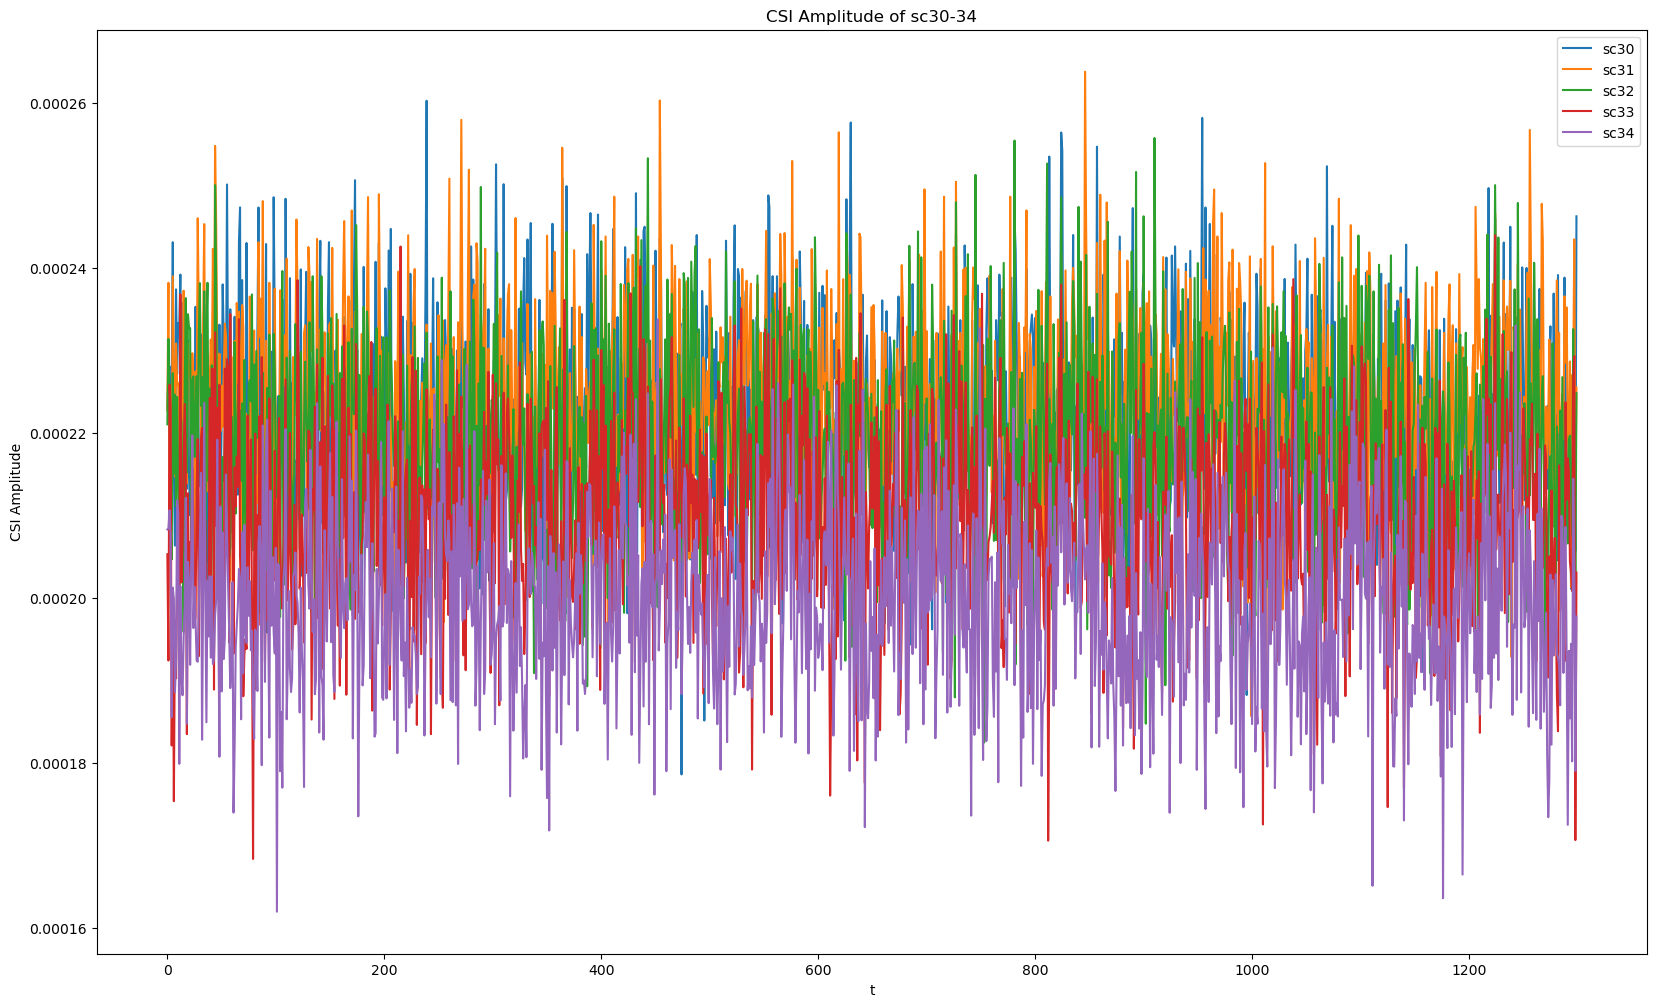

In [23]:
import matplotlib.pyplot as plt
# 计算同一接收天线的不同子载波的CSI幅度
tx = 0
rx = 0
iSamp = 0
sc = range(30, 35)

CSI_samp = CSI_s_amp[iSamp][rx,tx,sc,:].T
# print(sampp.shape)
# print(type(sampp))
# 绘制rx=0、tx=0情况下sc0-9的CSI幅度
plt.figure(figsize=(20, 12))
plt.plot(CSI_samp)
plt.xlabel('t')
plt.ylabel('CSI Amplitude')
plt.title('CSI Amplitude of sc%d-%d' % (sc[0], sc[-1]))
legend = ["sc"+str(i) for i in sc]
plt.legend(legend)
plt.show()


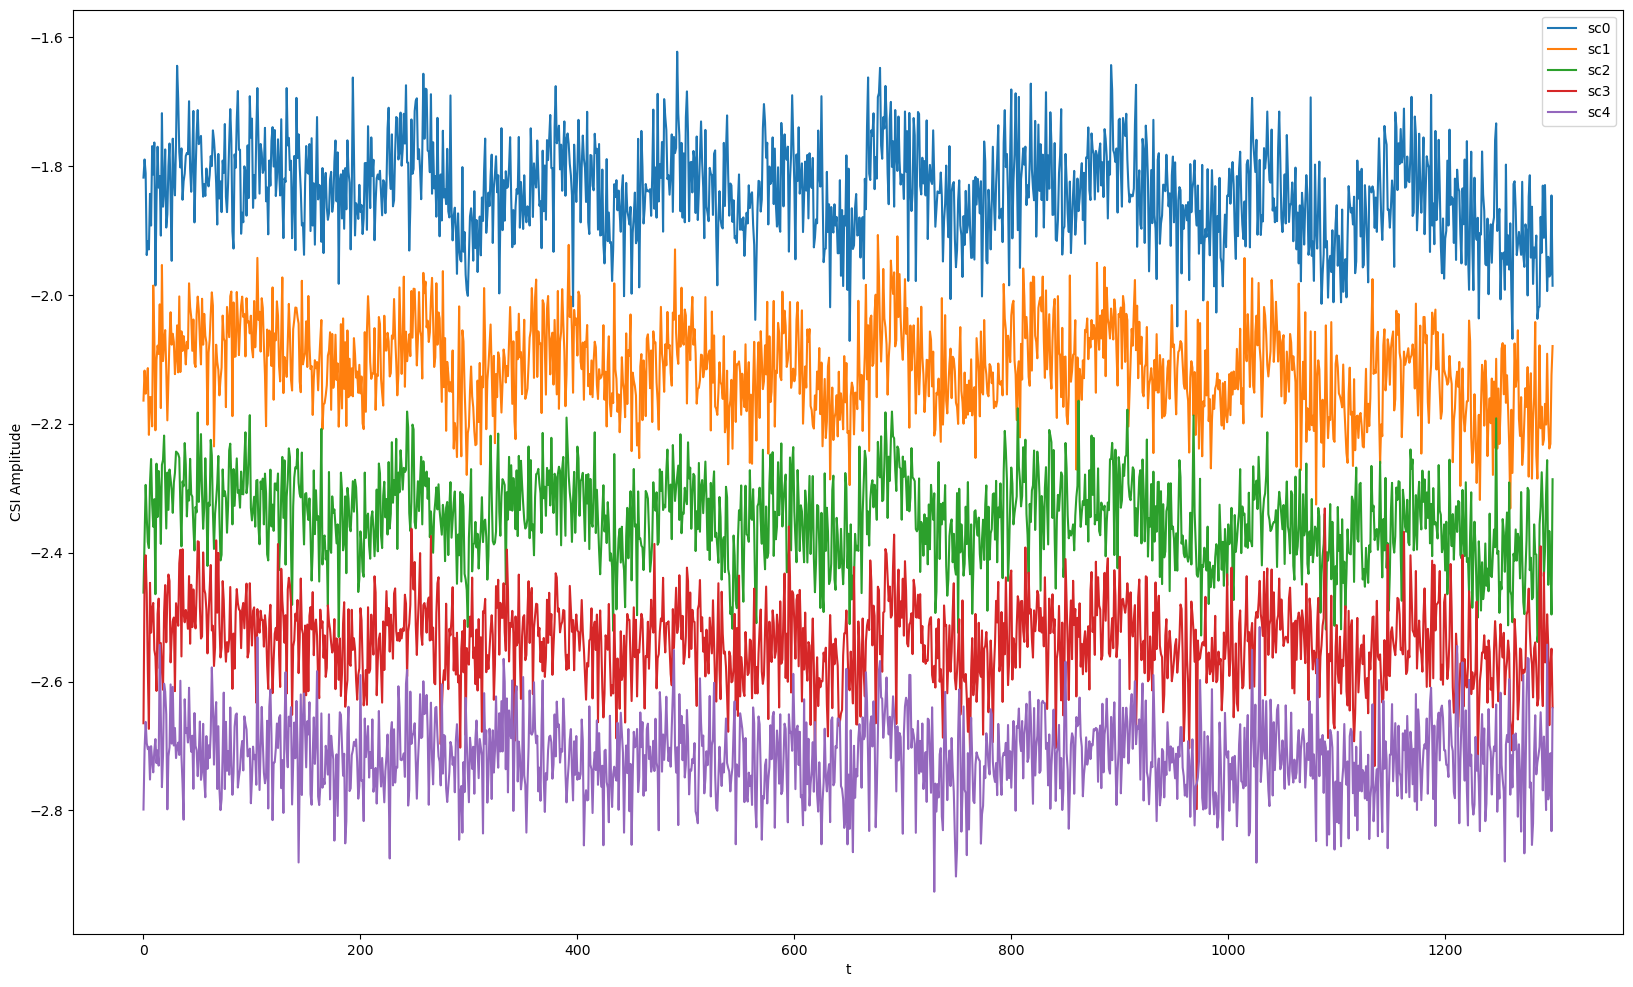

In [19]:
# 计算同一接收天线的不同子载波的CSI相位
CSI_samp = CSI_s_pha[iSamp][rx,tx,30:35,:].T
# print(sampp.shape)
# print(type(sampp))
# 绘制rx=0、tx=0情况下sc0-9的CSI幅度
plt.figure(figsize=(20, 12))
plt.plot(CSI_samp)
plt.xlabel('t')
plt.ylabel('CSI Amplitude')
plt.show()

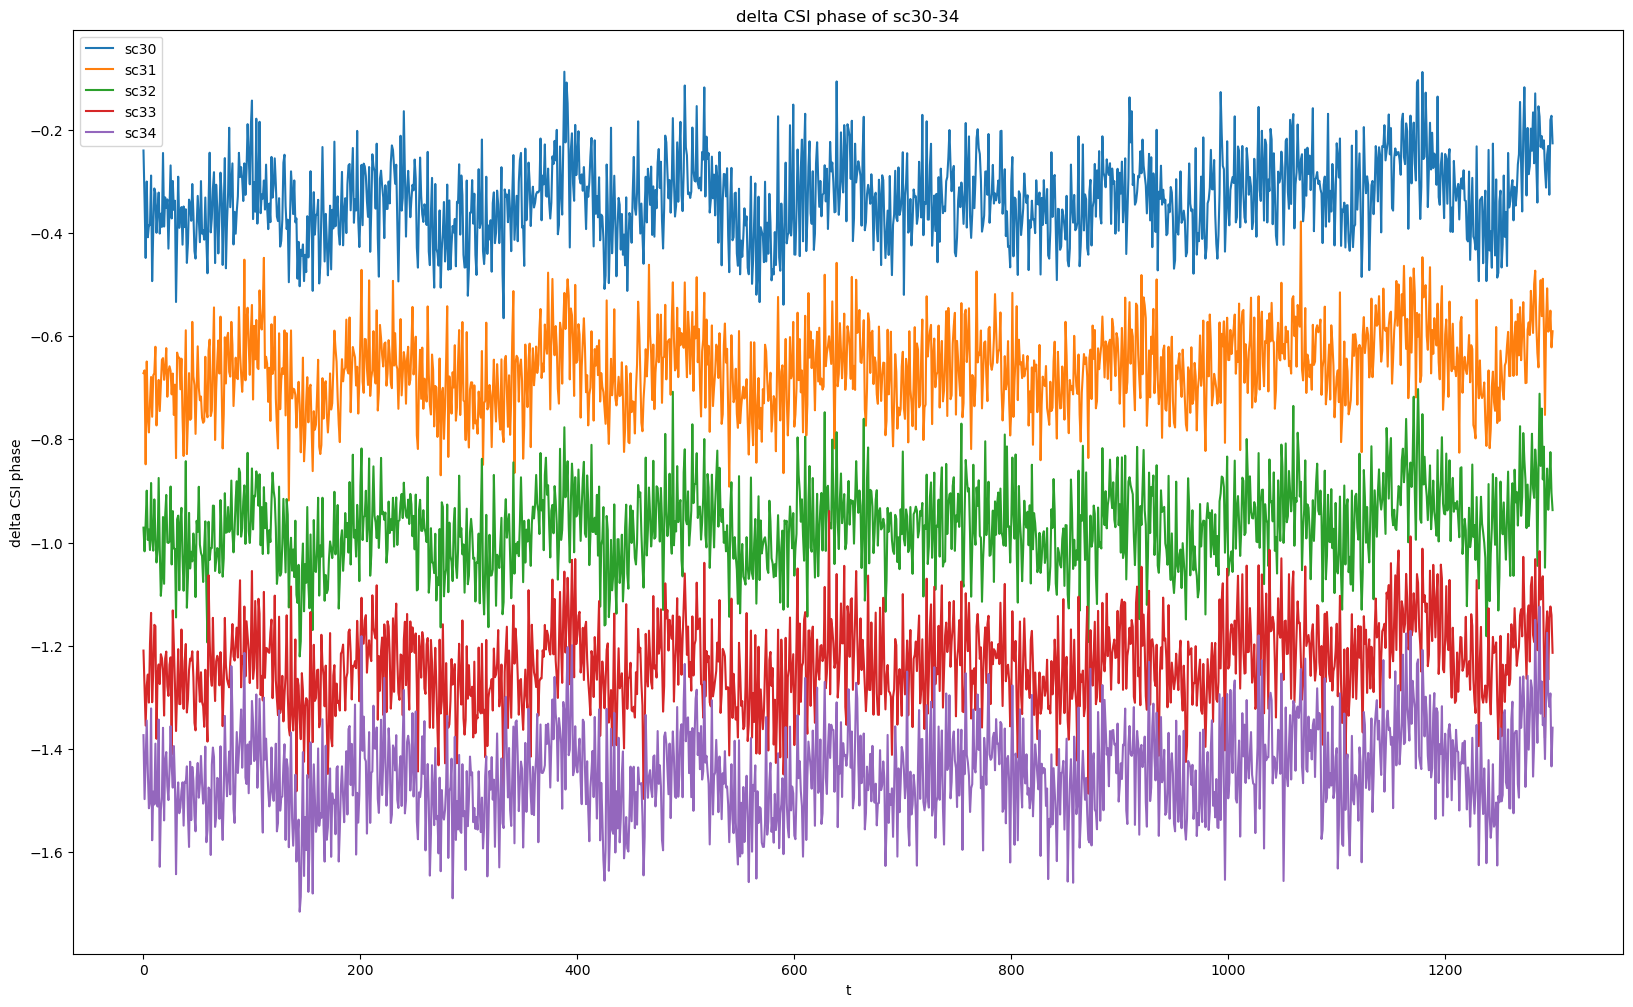

In [24]:
# 以sc0为基准，计算同一发射天线的不同子载波的CSI相位差
CSI_samp_all = CSI_s_pha[iSamp][rx,tx,:,:].T
CSI_samp = CSI_samp_all[:,sc] - CSI_samp_all[:,0].reshape(-1,1)

plt.figure(figsize=(20, 12))
plt.plot(CSI_samp)
plt.xlabel('t')
plt.ylabel('delta CSI phase')
plt.title('delta CSI phase of sc%d-%d' % (sc[0], sc[-1]))
legend = ["sc"+str(i) for i in sc]
plt.legend(legend)
plt.show()

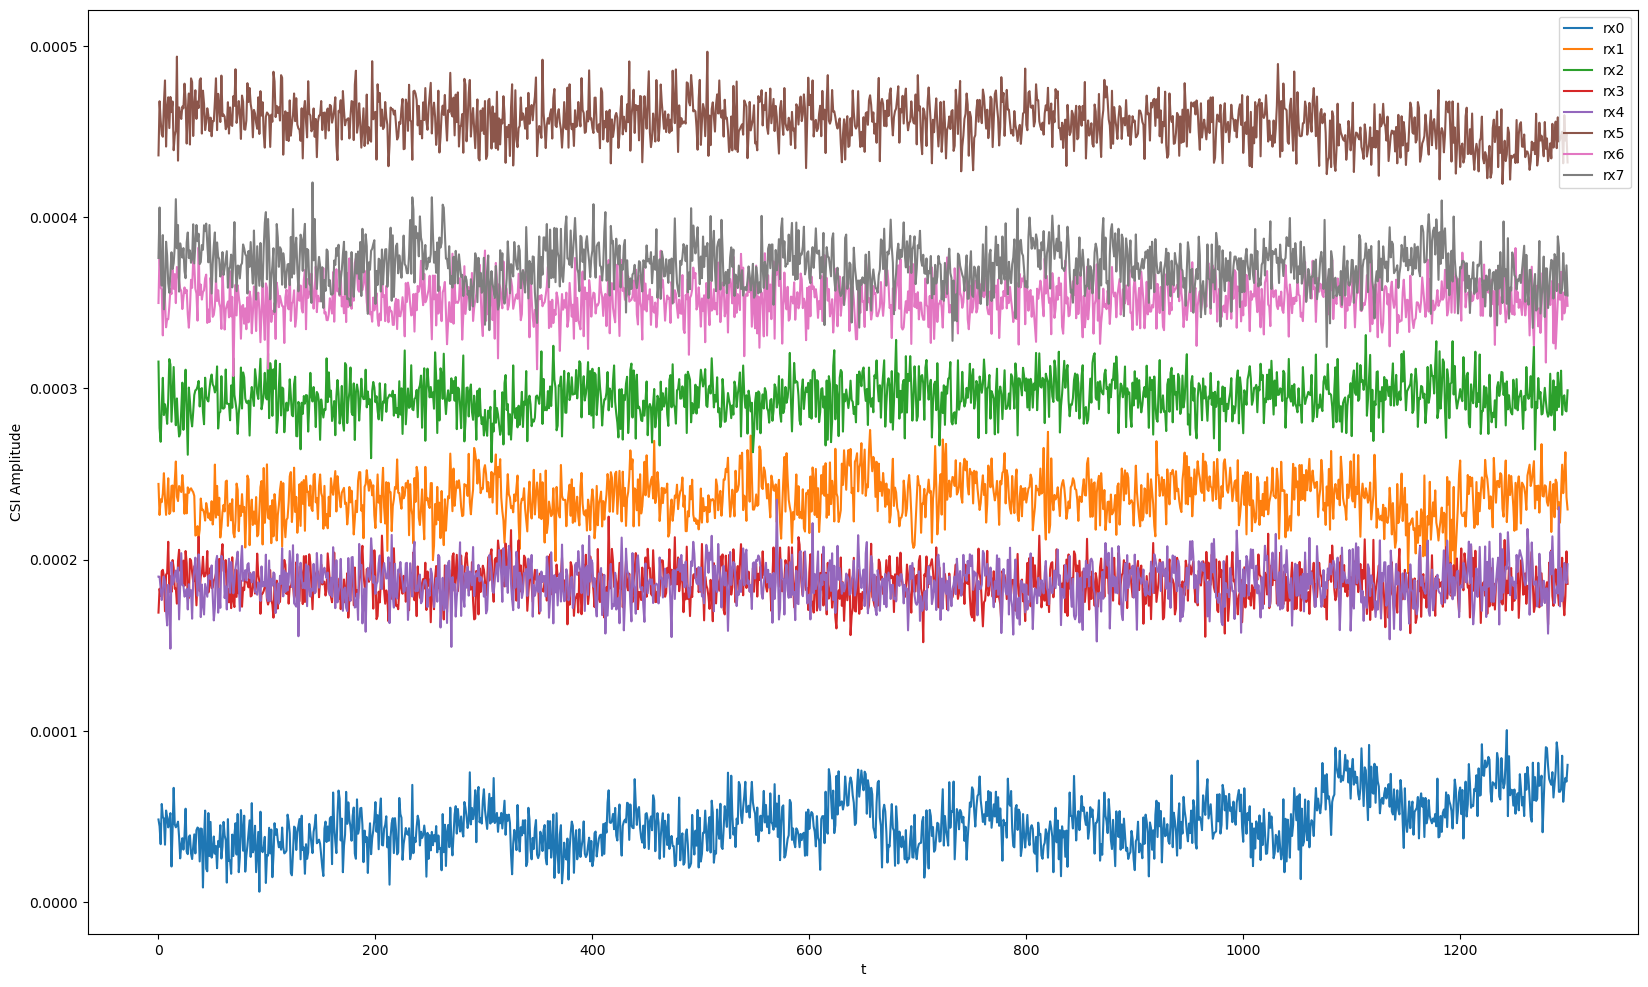

In [18]:
# 计算不同接收天线的同一子载波的CSI幅度
sc = 10
iSamp = 10

CSI_samp = CSI_s_amp[iSamp][:,:,sc,:].squeeze().T

plt.figure(figsize=(20, 12))
plt.plot(CSI_samp)
plt.xlabel('t')
plt.ylabel('CSI Amplitude')
# plt.title('CSI Amplitude of rx0-7')
plt.legend(['rx0', 'rx1', 'rx2', 'rx3', 'rx4', 'rx5', 'rx6', 'rx7'])
plt.show()

In [7]:
%matplotlib widget
from scipy.signal import savgol_filter
from sklearn.preprocessing import scale

rx = 0
tx = 0

fs_ = samp.Cfg['Nt'] / samp.Cfg['Tdur']  # 采样频率
BPMresol = 0.1
resol = BPMresol / 60  # 要分辨出0.1BPM，需要的频率分辨率
Ndft_ = np.array(fs_ / resol, dtype=int)  # DFT点数

breathEnd = 1  # 呼吸最高频率 Hz
dftSize = int(breathEnd / resol)  # DFT宽度

psd_bg = np.zeros((samp.Cfg['Nsamp'], dftSize), dtype=complex)
psd_ = np.empty((samp.Cfg['Nsc'], samp.Cfg['Nsamp'], dftSize), dtype=complex)

for sc in range(samp.Cfg['Nsc']):
    for ii in range(samp.Cfg['Nsamp']):
        # rx0 = CSI_s[ii][0][tx][sc] / np.mean(CSI_s[ii][0][tx][sc])
        # rx1 = CSI_s[ii][1][tx][sc] / np.mean(CSI_s[ii][1][tx][sc])
        # if np.any(rx0 == 0):
        #     print(sc, ii)
        #     csi_norm = np.abs(CSI_s[ii][rx][tx][sc]) / np.mean(np.abs(CSI_s[ii][rx][tx][sc]))
        # else:
        #     csi_norm = np.abs(CSI_s[ii][rx][tx][sc]) / np.abs(rx0) / np.mean(np.abs(CSI_s[ii][rx][tx][sc]))
        # csi_norm = np.abs(np.angle(CSI_s[ii][0][tx][sc]) - np.angle(CSI_s[ii][1][tx][sc]))

        # realSmooth = savgol_filter(Sreal[i], 8, 7)  # 用Savitzky-Golay滤波器平滑曲线
        # imagSmooth = savgol_filter(Simag[i], 8, 7)
        # pattern = np.empty_like(realSmooth)
        # patternVar = 0
        # for theta in np.linspace(0, 2 * np.pi, 100):
        #     pattern_ = np.cos(theta) * realSmooth + np.sin(theta) * imagSmooth
        #     patternVar_ = np.var(pattern_)
        #     if patternVar_ > patternVar:
        #         patternVar = patternVar_
        #         pattern = pattern_
        # patterns_.append(pattern)
        psd_[sc][ii] = np.fft.fft(scale(savgol_filter(CSI_s[ii][rx][tx][sc], 8, 7)), Ndft_[ii])[:dftSize]
        # psd_[sc][ii] = savgol_filter(np.abs(psd_[sc][ii]), 9, 3)
        # psd_[sc][ii] = np.fft.fft(scale(savgol_filter(np.abs(CSI_s[ii][rx][tx][sc]), 8, 7)), Ndft_[ii])[:dftSize]
        # psd_[sc][ii] = np.fft.fft(CSI_s[ii][rx][tx][sc], Ndft_[ii])[:dftSize]
        # plt.plot(np.abs(psd_[sc][ii]))
        psd_bg[ii] += psd_[sc][ii]
for ii in range(samp.Cfg['Nsamp']):
    psd_bg[ii] = savgol_filter(np.abs(psd_bg[ii] / samp.Cfg['Nsc']), 9, 3)
# psd_bg = np.mean(psd_, axis=(0,1))

/shared/conda/envs/bolt/lib/python3.10/site-packages/scipy/signal/_savitzky_golay.py:339: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)
/shared/conda/envs/bolt/lib/python3.10/site-packages/scipy/signal/_savitzky_golay.py:339: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)
/shared/conda/envs/bolt/lib/python3.10/site-packages/scipy/signal/_savitzky_golay.py:339: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)
/shared/conda/envs/bolt/lib/python3.10/site-packages/scipy/signal/_savitzky_golay.py:339: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)
/shared/conda/envs/bolt/lib/python3.10/site-packages/scipy/signal/_savitzky_golay.py:339: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)
/shared/conda/envs/bolt/lib/python3.10/s

0.4590131327214786
-1.3591090685804172
0 [21.5 19.2 37.3 26.1 40.3 30.  32.6 10.1 16.2  6.5] 1252.2301960753452


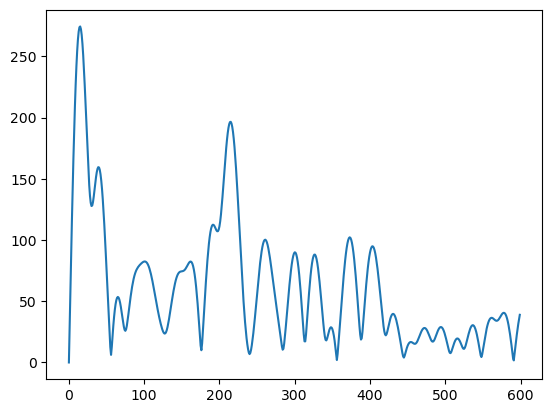

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, lfilter
from scipy.stats import kurtosis, skew
from scipy import signal

def zero_crossing_rate(x):
    return np.sum(np.abs(np.diff(np.sign(x)))) / len(x)
ii = 38
sc = 0
# x = savgol_filter(np.abs(psd_[sc][ii]), 10, 2)
x = np.abs(psd_[sc][ii])
# b, a = signal.butter(2, 0.3)
# zi = signal.lfilter_zi(b, a)
# x, _ = lfilter(b, a, np.abs(psd_[sc][ii]), zi=zi * np.abs(psd_[sc][ii][0]))
freq = np.abs(np.fft.fft(x))
print(np.sum(freq[100:]) / np.sum(freq))
print(kurtosis(x[9:32]))
plt.plot(x)
# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, x)
# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(psd_bg[ii]))
# x = psd_bg[ii] - np.mean(psd_bg[ii])
# print(np.var(x[int(5/BPMresol):int(50/BPMresol)]) / np.max(x[int(5/BPMresol):int(50/BPMresol)]))


bpms = []
idx, _ = find_peaks(x, height=0.1, distance=3, width=3)
# 输出 idx 中大于5 小于50 的值
idx = idx[np.where((idx * BPMresol> 5 ) & (idx * BPMresol< 50 ))]
idx = idx[np.argsort(-x[idx])][:10]
var = np.var(np.abs(x[idx]))
bpm = idx * BPMresol
print(sc, bpm, var)
bpms.append(bpm)

0 [21 26 37 30 40 10 16 33 43 47] 1521.4376276202122 242.06402836282908
1 [21  9 24 16 12 28 37 44 34 40] 3414.527122942726 258.5512218265593
2 [21 24 10 29  6 15 38 43 34] 5207.739383455179 264.5050562668968
3 [21 24 29 10  6 33 36 41 49 45] 9479.602898492714 324.8245557866341
4 [22 29 10  6 19 40 33 36 46] 10302.928438751476 330.23418143615936
5 [22 25 29  6 10 19 15 34 49 38] 10678.519507277626 370.2617153398541
6 [22 29  8 12 40 15 33 43 47] 7300.883115939334 318.0387426656679
7 [22 25 29  8 38 19 43 33 13 48] 3705.171817289955 313.21271814198894
8 [43 25 30 38  8 20 33 16 13] 513.2477776051848 241.39046159401204
9 [21 11 24  7 16 37 43 29 33] 2488.198768624127 215.05618973727601
10 [22 19 10  6 29 15 44 48 36 32] 6867.238478573081 328.02471582680596
11 [22 25 10 19 29  6 15 46 42 39] 10730.272727576781 415.24759813534985
12 [22 19 29  8 12 34 37 46 43] 17693.974996822028 486.9033771560048
13 [22  8 25 19 29 15 40 46 43 34] 15045.647434137703 496.0062022527775
14 [22  8 25 19 29 34

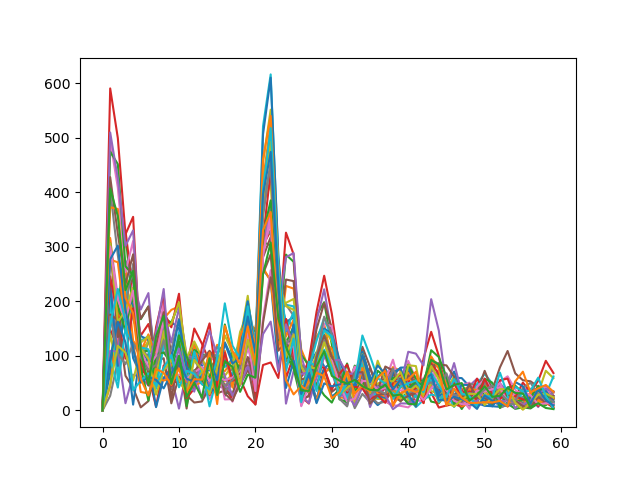

No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970


In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
# plt.plot(np.abs(CSI_s[0][0][0][0]))
# plt.plot(savgol_filter(np.abs(CSI_s[0][0][0][0]), 8, 7))

# for sc in range(samp.Cfg['Nsc']):
#     plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(psd_[sc][ii]))
# sc = 2
# for ii in range(samp.Cfg['Nsamp']):
#     plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(psd_[sc][ii]))

# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.angle(psd_bg))

bpms = []
vars_ = []
for sc in range(samp.Cfg['Nsc']):
    idx, _ = find_peaks(np.abs(psd_[sc][ii]), height=0.1, distance=3/BPMresol)
    # 输出 idx 中大于5 小于50 的值
    idx = idx[np.where((idx * BPMresol> 5 ) & (idx * BPMresol< 50 ))]
    idx = idx[np.argsort(-np.abs(psd_[sc][ii][idx]))][:10]
    var = np.var(np.abs(psd_[sc][ii][idx]))
    peaks = np.abs(psd_[sc][ii][int(5/BPMresol):int(50/BPMresol)])
    vars_.append(var)
    if var > 3000:
        plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(psd_[sc][ii]))
    bpm = idx * BPMresol
    print(sc, bpm, var, np.max(np.abs(psd_[sc][ii])))
    bpms.append(bpm)

[21 10 26 30 16 43 33 37  6 40 47]
[898 287 250  77  73  63  22   5   4   2   0]


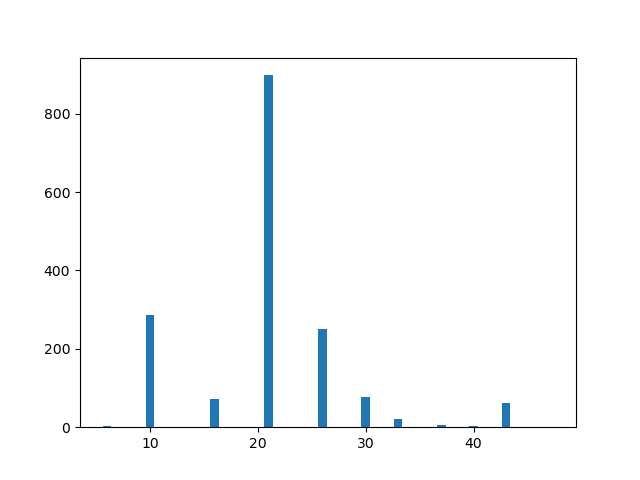

In [5]:
%matplotlib widget
ini = 0
centroids = bpms[ini] # 初始化质心
if len(centroids) == 0:
     ini = 1
     centroids = bpms[ini]
score = [20, 18, 2, 1, 0, 0, 0, 0, 0, 0]
if samp.Cfg['Np'][ii] > 1:
    score = [20, 18, 15, 1, 0, 0, 0, 0, 0, 0]
vote = np.array(score[:len(bpms[ini])])
clusters = [[bpms[ini][i]] for i in range(len(bpms[ini]))]
minvar = min(vars_)
maxvar = max(vars_)

for sc in range(ini, samp.Cfg['Nsc']):
    # if vars_[sc] < (maxvar - minvar) * 0.5 + minvar:
    #     continue
    for i in range(len(bpms[sc])):
        diff = np.abs(centroids - bpms[sc][i])
        # 若新的峰值与已有质心的距离都大于2BPM，则认为是新的质心
        if np.min(diff) > 3:
            centroids = np.append(centroids, bpms[sc][i])
            vote = np.append(vote, score[i])
            clusters.append([bpms[sc][i]])
        else:
            vote[np.argmin(diff)] += score[i]
            clusters[np.argmin(diff)].append(bpms[sc][i])
            # centroids[np.argmin(diff)] = np.mean(clusters[np.argmin(diff)])

plt.bar(centroids, vote)
centroids = centroids[np.argsort(-vote)]
print(centroids)
print(vote[np.argsort(-vote)])